In [1]:
import numpy as np
import scipy.sparse as sp
import pandas as pd
import sknetwork as sn
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from tqdm import tqdm
from fstar import fstar

from cove import COVE
from cove.dimension_reduction import LaplacianEigenmap, UMAPLE
from utils import *

In [2]:
import warnings
from numba.core.errors import NumbaExperimentalFeatureWarning
import sklearn.utils.deprecation

warnings.simplefilter("ignore", category=NumbaExperimentalFeatureWarning)
warnings.simplefilter("ignore", category=FutureWarning)

In [3]:
def hex2rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16)/255. for i in range(0, lv, lv // 3))

In [10]:
n = 1000
RUNS = 20
xis = np.linspace(0.1, 0.7, 13)
n_walks = 10
walk_len = 40
window_size=7

methods = ["COVE+UMAP", "COVE+UMAPLE", "COVE+SVD", "N2V", "N2V+UMAP", "Louvain"]
colors = [hex2rgb("#59a89c"), hex2rgb("#f0c571"), hex2rgb("#e02b35"), hex2rgb("#082a54"), hex2rgb("#894723"), hex2rgb("#125643")]

In [11]:
np.random.seed(42)

vectorizer = COVE(window_length=window_size, walks_per_node = n_walks, walk_length = walk_len)
clusterer = HDBSCAN()
louvain = sn.clustering.Louvain()

performance = np.zeros((6, len(xis), RUNS), dtype="float64")
with tqdm(total=len(xis)*RUNS) as pbar:
    for i, xi in enumerate(xis):            
        for j in range(RUNS):
            adjacency, labels = abcd(n, xi)

            high = vectorizer.fit(adjacency).cooccurance_csr_
            low = UMAP(metric="hellinger").fit_transform(high)
            predict = clusterer.fit_predict(low)
            performance[0, i, j] = fstar(predict, labels)

            low = UMAPLE(dimension=2, metric="hellinger").fit_transform(high, adjacency)
            predict = clusterer.fit_predict(low)
            performance[1, i, j] = fstar(predict, labels)

            low = TruncatedSVD(n_components=2).fit_transform(high)
            predict = clusterer.fit_predict(low)
            performance[2, i, j] = fstar(predict, labels)

            low = node2vec(adjacency, 2, num_walks=n_walks, walk_length=walk_len, window_size=window_size)
            predict = clusterer.fit_predict(low)
            performance[3, i, j] = fstar(predict, labels)

            high = node2vec(adjacency, 64, num_walks=n_walks, walk_length=walk_len, window_size=window_size)
            low = UMAP(metric="cosine").fit_transform(high)
            predict = clusterer.fit_predict(low)
            performance[4, i, j] = fstar(predict, labels)

            predict = louvain.fit_predict(adjacency)
            performance[5, i, j] = fstar(predict, labels)
            pbar.update()


np.save("clustering_performance.npy", performance)
print("Simulation Finished")

100%|██████████| 260/260 [38:21<00:00,  8.85s/it]

Simulation Finished


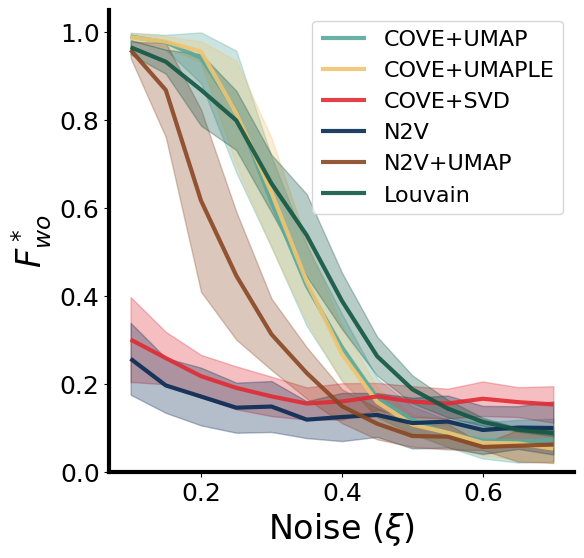

In [13]:
# plot results
means = np.mean(performance, axis=2)
stds = np.std(performance, axis=2)

fig, ax = plt.subplots(1,1, figsize = (6,6))

for i in range(performance.shape[0]):
    ax.plot(xis, means[i], color = colors[i],
                label = methods[i], alpha = 0.9, lw = 3, dashes = [500,1])
for i in range(performance.shape[0]):
    ax.fill_between(xis, means[i] - stds[i], means[i] + stds[i], 
                        color = colors[i], alpha = 0.3)


ax.set_ylim([0.0, 1.05])
#ax.set_yticks([0.0, 0.5, 1.0])
ax.tick_params(labelsize=18)

ax.set_xlabel(r'Noise $(\xi)$', fontsize=24)
ax.set_ylabel(r'$F^*_{wo}$', fontsize=24)

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(3)

ax.legend(labels=methods, fontsize=16)
#set_size(5,5)
plt.show()

# Real Data

In [5]:
graphs = ["football", "primary1", "primary2", "hci", "highschool", "cora_small", "airport"]
min_cluster_size = [5, 10, 10, 40, 15, 40, 100]
data = []

np.random.seed(42)
vectorizer = COVE(window_length=window_size, walks_per_node = n_walks, walk_length = walk_len)
louvain = sn.clustering.Louvain()

for i, graph in enumerate(graphs):
    print(graph)
    adjacency, labels = load_graph(graph)
    clusterer = HDBSCAN(min_cluster_size=min_cluster_size[i])

    print("\tCOVE+UMAP")
    high = vectorizer.fit(adjacency).cooccurance_csr_
    low = UMAP(metric="hellinger").fit_transform(high)
    predict = clusterer.fit_predict(low)
    fs = fstar(predict, labels)
    nofs = fstar(predict, labels, drop_outliers="c1")
    data.append({"method":"COVE+UMAP", "name":graph, "FSTAR":fs, "NO-FSTAR":nofs, "Coverage":np.sum(predict >= 0)/len(predict)})
    
    print("\tCOVE+UMAPLE")
    low = UMAPLE(dimension=2, metric="hellinger").fit_transform(high, adjacency)
    predict = clusterer.fit_predict(low)
    fs = fstar(predict, labels)
    nofs = fstar(predict, labels, drop_outliers="c1")
    data.append({"method":"COVE+UMAPLE", "name":graph, "FSTAR":fs, "NO-FSTAR":nofs, "Coverage":np.sum(predict >= 0)/len(predict)})

    print("\tCOVE+SVD")
    low = TruncatedSVD(n_components=2).fit_transform(high)
    predict = clusterer.fit_predict(low)
    fs = fstar(predict, labels)
    nofs = fstar(predict, labels, drop_outliers="c1")
    data.append({"method":"COVE+SVD", "name":graph, "FSTAR":fs, "NO-FSTAR":nofs, "Coverage":np.sum(predict >= 0)/len(predict)})

    print("\tN2V")
    low = node2vec(adjacency, 2, num_walks=n_walks, walk_length=walk_len, window_size=window_size)
    predict = clusterer.fit_predict(low)
    fs = fstar(predict, labels)
    nofs = fstar(predict, labels, drop_outliers="c1")
    data.append({"method":"N2V", "name":graph, "FSTAR":fs, "NO-FSTAR":nofs, "Coverage":np.sum(predict >= 0)/len(predict)})

    print("\tN2V+UMAP")
    high = node2vec(adjacency, 64, num_walks=n_walks, walk_length=walk_len, window_size=window_size)
    low = UMAP(metric="cosine").fit_transform(high)
    predict = clusterer.fit_predict(low)
    fs = fstar(predict, labels)
    nofs = fstar(predict, labels, drop_outliers="c1")
    data.append({"method":"N2V+UMAP", "name":graph, "FSTAR":fs, "NO-FSTAR":nofs, "Coverage":np.sum(predict >= 0)/len(predict)})

    print("\tLouvain")
    predict = louvain.fit_predict(adjacency)
    fs = fstar(predict, labels)
    nofs = fstar(predict, labels, drop_outliers="c1")
    data.append({"method":"Louvain", "name":graph, "FSTAR":fs, "NO-FSTAR":nofs, "Coverage":np.sum(predict >= 0)/len(predict)})
    
    print()
    print()

df = pd.DataFrame(data)
df.to_pickle("clustering_real.pkl")

football
	COVE+UMAP
	COVE+UMAPLE
	COVE+SVD
	N2V
	N2V+UMAP
	Louvain


primary1
	COVE+UMAP
	COVE+UMAPLE
	COVE+SVD
	N2V
	N2V+UMAP
	Louvain


primary2
	COVE+UMAP
	COVE+UMAPLE
	COVE+SVD
	N2V
	N2V+UMAP
	Louvain


hci
	COVE+UMAP
	COVE+UMAPLE
	COVE+SVD
	N2V
	N2V+UMAP
	Louvain


highschool
	COVE+UMAP
	COVE+UMAPLE
	COVE+SVD
	N2V
	N2V+UMAP
	Louvain


cora_small
	COVE+UMAP


/Users/ryandewolfe/miniforge3/envs/COVE/lib/python3.13/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/ryandewolfe/miniforge3/envs/COVE/lib/python3.13/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/ryandewolfe/miniforge3/envs/COVE/lib/python3.13/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


	COVE+UMAPLE
	COVE+SVD
	N2V
	N2V+UMAP
	Louvain


airport
	COVE+UMAP
	COVE+UMAPLE
	COVE+SVD
	N2V
	N2V+UMAP
	Louvain




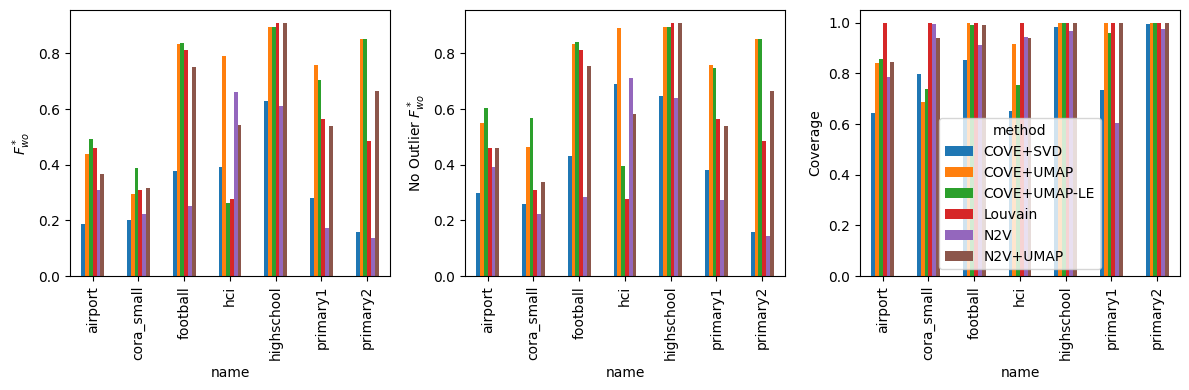

In [6]:
df2 = df.groupby(["name", "method"]).mean()
fig, axs = plt.subplots(1,3, figsize=(12,4))
df2["FSTAR"].unstack().plot(kind="bar", ax = axs[0], legend=False)
axs[0].set_ylabel(r"$F^*_{wo}$")
df2["NO-FSTAR"].unstack().plot(kind="bar", ax=axs[1], legend=False)
axs[1].set_ylabel(r"No Outlier $F^*_{wo}$")
df2["Coverage"].unstack().plot(kind="bar", ax=axs[2], legend=True)
axs[2].set_ylabel("Coverage")
plt.tight_layout()